In [1]:
# Example of: https://bikeshbade.com.np/tutorials/Detail/?title=Chirps%20Precipitation%20to%20Excel%20-%20GEE%20and%20Pandas&code=14
# import Google earth engine module
import ee

#Authenticate the Google earth engine with google account
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AWtgzh7R8JArSzg95W4fTtq9fK0YK22uAEh7rCxZXzEEHqcCtQlewQZSZ_o



Successfully saved authorization token.


In [24]:
#Pandas modules to interact data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Comic Sans MS"

%matplotlib inline

In [ ]:
# Boyacá: 04°39′10″ - 07°03′17″ Lat North & 71°57′49″ - 74°41’35″ Lon West
# Decimals: 4.6527778 - 7.0547222 & -71.96361111111112 - -74.69305555555556
# Center Lat: (7.0547222 - 4.6527778)/2 + 4.6527778  
# Center Lon: -[(74.69305555555556 - 71.96361111111112)/2] - 71.96361111111112

In [50]:


lat, lon =  (7.0547222-4.6527778)/2+4.6527778, -((74.69305555555556 - 71.96361111111112)/2) - 71.96361111111112
buffer_lat, buffer_lon = 1.23, 1.37

time_period = ('2020')

output_crs = 'epsg:6933'

#join lat,lon,buffer to get bounding box
lon_range = (lon - buffer_lon, lon + buffer_lon)
lat_range = (lat + buffer_lat, lat - buffer_lat)
print(lon_range,lat_range)

(-74.69833333333335, -71.95833333333334) (7.08375, 4.623749999999999)


In [313]:
# import the RS products
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
from datetime import datetime, timedelta

# Define time range
startyear = 2020
endyear = 2020

startmonth = 1
endmonth = 1

startday = 1
endday = 30

# Set date in ee date format
startdate_ee = ee.Date.fromYMD(startyear,startmonth,startday)
enddate_ee = ee.Date.fromYMD(endyear,endmonth,endday)

startdate = datetime(startyear,startmonth,startday)
enddate = datetime(endyear,endmonth,endday)

list_dates = [startdate + timedelta(days=d) for d in range((enddate - startdate).days + 1)] 
print(list_dates)




#Filter to select Precipitation band
PrecipitationChirps = chirps.filterDate(startdate, enddate).sort('system:time_start', False).select("precipitation")
# print(PrecipitationChirps)
# Define geograpic 
point = ee.Geometry.Polygon([[-71.9636,4.65 ],
                           [-71.9636, 7.054],
                           [-74.69306, 4.65],
                           [-74.69306, 7.054]])

    
def diff_dates(date1, date2):
    return abs(date2-date1).days

# calculate the monthly Sum
def DailySum(imageCollection):
    mylist = ee.List([])
    for date in list_dates:
        print(date)
        year = date.year
        month = date.month
        day = date.day
        w = imageCollection.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).filter(ee.Filter.calendarRange(day, day, 'DAY_OF_MONTH')).sum()
        #mylist = mylist.add(w)
        mylist = mylist.add(w.set('year', year).set('month', month).set('date', ee.Date.fromYMD(year,month,day)).set('system:time_start',ee.Date.fromYMD(year,month,day)))
    return ee.ImageCollection.fromImages(mylist)
 
# run the calcMonthlyMean function
dailyChirps = ee.ImageCollection(DailySum(PrecipitationChirps))

# select the region of interest, 25000 is the cellsize in meters
dailyChirps = dailyChirps.getRegion(point,25000,"epsg:4326").getInfo()
print(dailyChirps)

# get january (index = 0)
precipiation = pd.DataFrame(dailyChirps, columns = dailyChirps[0])
print(precipiation)

# remove the first line
precipiation = precipiation[1:]
print(precipiation)

#to display the data
print(precipiation[['id','longitude','latitude','precipitation']])

#To export to CSV
precipiation.to_csv (r'precipitation.csv', index = False, header=True)

[datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 1, 2, 0, 0), datetime.datetime(2020, 1, 3, 0, 0), datetime.datetime(2020, 1, 4, 0, 0), datetime.datetime(2020, 1, 5, 0, 0), datetime.datetime(2020, 1, 6, 0, 0), datetime.datetime(2020, 1, 7, 0, 0), datetime.datetime(2020, 1, 8, 0, 0), datetime.datetime(2020, 1, 9, 0, 0), datetime.datetime(2020, 1, 10, 0, 0), datetime.datetime(2020, 1, 11, 0, 0), datetime.datetime(2020, 1, 12, 0, 0), datetime.datetime(2020, 1, 13, 0, 0), datetime.datetime(2020, 1, 14, 0, 0), datetime.datetime(2020, 1, 15, 0, 0), datetime.datetime(2020, 1, 16, 0, 0), datetime.datetime(2020, 1, 17, 0, 0), datetime.datetime(2020, 1, 18, 0, 0), datetime.datetime(2020, 1, 19, 0, 0), datetime.datetime(2020, 1, 20, 0, 0), datetime.datetime(2020, 1, 21, 0, 0), datetime.datetime(2020, 1, 22, 0, 0), datetime.datetime(2020, 1, 23, 0, 0), datetime.datetime(2020, 1, 24, 0, 0), datetime.datetime(2020, 1, 25, 0, 0), datetime.datetime(2020, 1, 26, 0, 0), datetime.datetime(20

In [314]:
import json 
import pandas as pd

precipiationTime = precipiation
precipiationTime['date'] = precipiation.apply(lambda x: json.dumps(x['time'])[25:39], axis = 1)

print(precipiationTime)
precipiationTime.head(140)
precipiationTime.describe()
precipiationTime.info()

      id  longitude  latitude                                      time  \
1      0 -74.672458  4.828445  {'type': 'Date', 'value': 1577836800000}   
2      1 -74.672458  4.828445  {'type': 'Date', 'value': 1577923200000}   
3      2 -74.672458  4.828445  {'type': 'Date', 'value': 1578009600000}   
4      3 -74.672458  4.828445  {'type': 'Date', 'value': 1578096000000}   
5      4 -74.672458  4.828445  {'type': 'Date', 'value': 1578182400000}   
...   ..        ...       ...                                       ...   
2142  24 -71.977512  6.849654  {'type': 'Date', 'value': 1579910400000}   
2143  25 -71.977512  6.849654  {'type': 'Date', 'value': 1579996800000}   
2144  26 -71.977512  6.849654  {'type': 'Date', 'value': 1580083200000}   
2145  27 -71.977512  6.849654  {'type': 'Date', 'value': 1580169600000}   
2146  28 -71.977512  6.849654  {'type': 'Date', 'value': 1580256000000}   

     precipitation            date  
1                0   1577836800000  
2                0   1577

In [315]:
from datetime import datetime


# Date only
precipiationTime['date_format'] = pd.to_datetime(precipiationTime['date'], unit='ms').dt.strftime("%Y-%m-%d")
precipiationTime.describe()

precipiationTime2 = precipiationTime.loc[precipiationTime['longitude'] > -72] 
precipiationTime2 = precipiationTime2.loc[precipiationTime2['latitude'] > 6.8] 
precipiationTime2

,id,longitude,latitude,time,precipitation,date,date_format
2118,0,-71.977512,6.849654,"{'type': 'Date', 'value': 1577836800000}",0,1577836800000,2020-01-01
2119,1,-71.977512,6.849654,"{'type': 'Date', 'value': 1577923200000}",0,1577923200000,2020-01-02
2120,2,-71.977512,6.849654,"{'type': 'Date', 'value': 1578009600000}",0,1578009600000,2020-01-03
2121,3,-71.977512,6.849654,"{'type': 'Date', 'value': 1578096000000}",0,1578096000000,2020-01-04
2122,4,-71.977512,6.849654,"{'type': 'Date', 'value': 1578182400000}",0,1578182400000,2020-01-05
2123,5,-71.977512,6.849654,"{'type': 'Date', 'value': 1578268800000}",0,1578268800000,2020-01-06
2124,6,-71.977512,6.849654,"{'type': 'Date', 'value': 1578355200000}",0,1578355200000,2020-01-07
2125,7,-71.977512,6.849654,"{'type': 'Date', 'value': 1578441600000}",0,1578441600000,2020-01-08
2126,8,-71.977512,6.849654,"{'type': 'Date', 'value': 1578528000000}",0,1578528000000,2020-01-09
2127,9,-71.977512,6.849654,"{'type': 'Date', 'value': 1578614400000}",0,1578614400000,2020-01-10


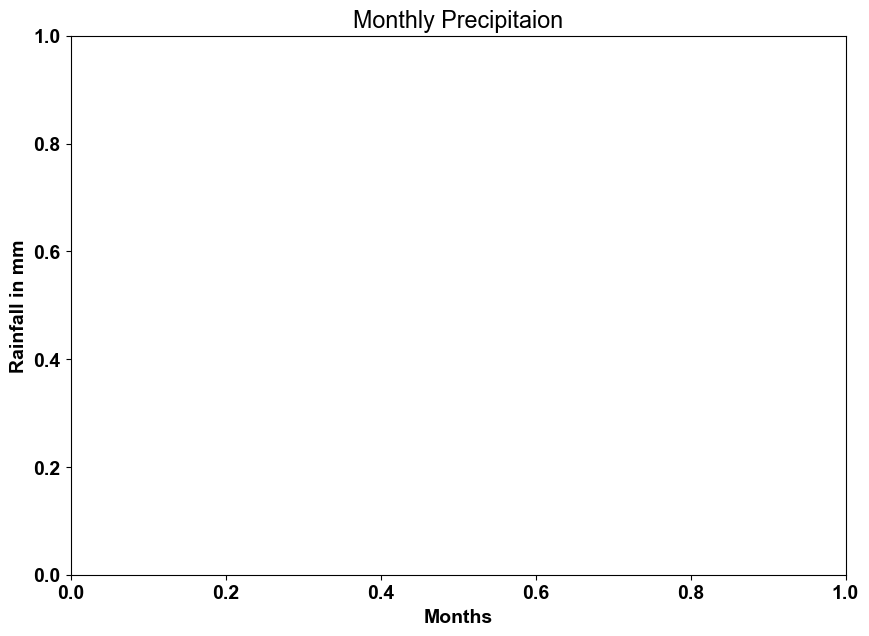

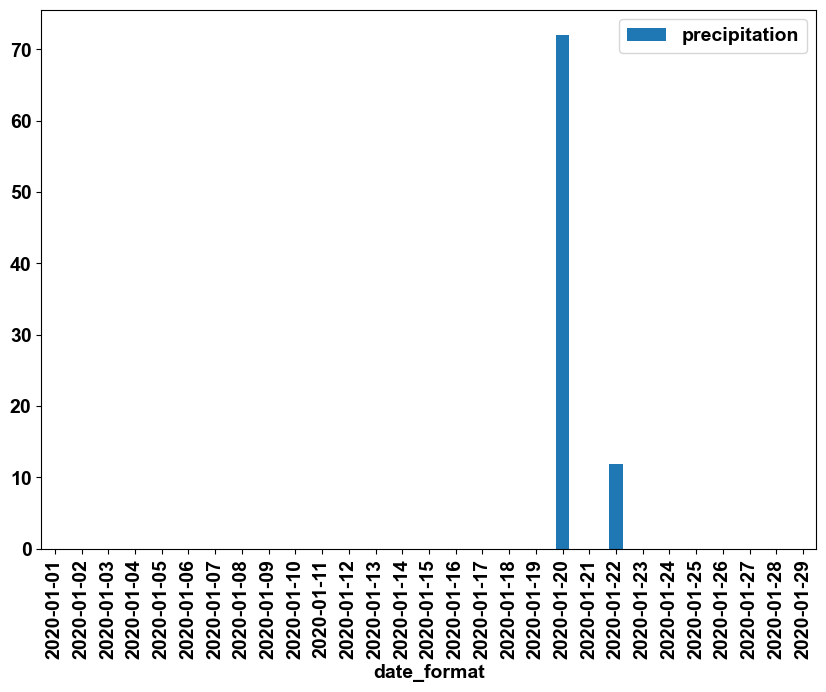

In [316]:
# To display the data in the chart
#style the font size
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

#chart Title
plt.title('Monthly Precipitaion')

#chart lable for x axis
plt.xlabel('Months')

#chart lable for y axis
plt.ylabel('Rainfall in mm')

plt.rcParams["figure.figsize"] = (10,7)

ax = precipiationTime2.plot.bar(x='date_format', y='precipitation', rot=90)

#export chart as png
plt.savefig('precipitation.png')